In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Functions for loading in qmc, vmc, and exact data (vmc and exact are together in one function)

In [3]:
def load_qmc_energy_data(data_dir, D="1D", L=12, N=12, M=12, l=2, t="1.0000", beta="1.0000", seed="2001", trialstate="constant"):
    """
    Load QMC kinetic and potential energy data, and compute total energy if both components are present.
    """
    import os
    import re
    import pandas as pd

    tag = f"{D}_L{L}_N{N}_M{M}_l{l}"
    pattern = re.compile(
        rf"(K|V)_{tag}_U([0-9.]+)_t{t}_beta{beta}_binsize10000_seed{seed}_square_trialstate_{trialstate}\.dat"
    )

    energy_data = {}

    for fname in os.listdir(data_dir):
        match = pattern.match(fname)
        if match:
            kind = match.group(1)
            U_val = float(match.group(2))
            fpath = os.path.join(data_dir, fname)
            # print(f"✔ Found file for U={U_val:.1f}, type={kind}: {fname}")  # Debug print

            df = pd.read_csv(fpath, delim_whitespace=True, header=None)
            mean = df[0].mean()
            std = df[0].std()

            if U_val not in energy_data:
                energy_data[U_val] = {}

            energy_data[U_val][f"{kind}_mean"] = mean
            energy_data[U_val][f"{kind}_std"] = std

    if not energy_data:
        raise ValueError(f"No matching QMC energy files found in {data_dir}")

    df_energy = pd.DataFrame.from_dict(energy_data, orient="index")
    df_energy.index.name = "U"
    df_energy.sort_index(inplace=True)

    # Only compute total energy if both components are present
    if "K_mean" in df_energy.columns and "V_mean" in df_energy.columns:
        df_energy["Total_mean"] = df_energy["K_mean"] + df_energy["V_mean"]
        df_energy["Total_std"] = (df_energy["K_std"]**2 + df_energy["V_std"]**2)**0.5
    else:
        print("⚠ Warning: Missing 'K_mean' or 'V_mean'. Total energy will not be computed.")

    return df_energy


def load_vmc_and_exact_data(vmc_path, exact_path):
    """Load VMC and exact diagonalization data and return merged dataframe."""
    df_vmc = pd.read_csv(vmc_path, delim_whitespace=True, comment='#', names=["U", "kappa", "energy", "sem", "$\\mu$"])
    df_exact = pd.read_csv(exact_path, delim_whitespace=True, comment="#", header=None)
    df_exact.columns = ["U", "Eg", "K", "V", "S₁(ℓ=5)", "S₁acc(ℓ=5)", "S₂(ℓ=5)", "S₂acc(ℓ=5)", "EN(ℓ=5)", "ENacc(ℓ=5)"]
    
    return pd.merge(df_exact, df_vmc, on="U")


def load_energy_components(vmc_path, exact_path):
    """
    Load kinetic and potential energy components (and std) from VMC and exact data files.

    Parameters:
        vmc_path (str): Path to the VMC energy parts file (U, T, σ_T, V, σ_V).
        exact_path (str): Path to the exact diagonalization data file.

    Returns:
        dict: Dictionary containing U values and energy components with std.
    """
    # Load VMC data with std dev
    vmc_data = np.loadtxt(vmc_path, comments="#")
    U_vmc = vmc_data[:, 0]
    E_kin_vmc = vmc_data[:, 1]
    E_kin_std_vmc = vmc_data[:, 2]
    E_pot_vmc = vmc_data[:, 3]
    E_pot_std_vmc = vmc_data[:, 4]

    # Load Exact data (no stds)
    exact_data = np.loadtxt(exact_path, comments="#")
    U_exact = exact_data[:, 0]
    E_total_exact = exact_data[:, 1]
    E_kin_exact = exact_data[:, 2]
    E_pot_exact = exact_data[:, 3]

    return {
        "U_vmc": U_vmc,
        "E_kin_vmc": E_kin_vmc,
        "E_kin_std_vmc": E_kin_std_vmc,
        "E_pot_vmc": E_pot_vmc,
        "E_pot_std_vmc": E_pot_std_vmc,
        "U_exact": U_exact,
        "E_kin_exact": E_kin_exact,
        "E_pot_exact": E_pot_exact
    }

# Functions for plotting total energy and energy components (kinetic and potential) separately

In [5]:
def plot_energy_comparison(df, df_qmc=None, title="Energy Comparison", save_path=None):
    """
    Plot total energy vs U for VMC and optionally QMC and Exact if available.

    Parameters:
        df (pd.DataFrame): VMC and optionally Exact data.
        df_qmc (pd.DataFrame or None): QMC data (optional).
        title (str): Plot title.
        save_path (str or None): Path to save the figure; if None, show plot.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))

    # VMC always present
    if "energy" in df.columns and "sem" in df.columns:
        plt.errorbar(df["U"], df["energy"], yerr=df["sem"], label="VMC", fmt="o", capsize=3, color='red')

    # Exact present in 1D only
    if "Eg" in df.columns:
        plt.plot(df["U"], df["Eg"], label="Exact", linestyle="--", marker = "d", color="black")

    # QMC
    if df_qmc is not None and "Total_mean" in df_qmc.columns:
        plt.errorbar(df_qmc.index, df_qmc["Total_mean"], yerr=df_qmc["Total_std"], label="QMC", fmt="o", capsize=3, color="blue")

    plt.xlabel("U")
    plt.ylabel("Total Energy")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()



import matplotlib.pyplot as plt

def plot_energy_components(data_dict, title_prefix, save_path=None):
    """
    Plot kinetic and potential energy components comparing VMC and Exact methods,
    including error bars for VMC.

    Parameters:
        data_dict (dict): Output of `load_energy_components` containing all data arrays.
        title_prefix (str): Optional prefix to prepend to subplot titles.
        save_path (str): If provided, the figure will be saved to this path.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # Kinetic energy plot
    if "E_kin_exact" in data_dict:
        axs[0].plot(data_dict["U_exact"], data_dict["E_kin_exact"],
                    label="Exact", linestyle="--", marker="d", color="black")

    axs[0].errorbar(data_dict["U_vmc"], data_dict["E_kin_vmc"],
                    yerr=data_dict["E_kin_std_vmc"],
                    label="VMC", marker="o", linestyle="-", color="red", capsize=3)

    axs[0].set_title(f"{title_prefix} – Kinetic Energy")
    axs[0].set_xlabel("U")
    axs[0].set_ylabel("⟨T⟩")
    axs[0].legend()
    axs[0].grid(True)

    # Potential energy plot
    if "E_pot_exact" in data_dict:
        axs[1].plot(data_dict["U_exact"], data_dict["E_pot_exact"],
                    label="Exact", linestyle="--", marker="d", color="black")

    axs[1].errorbar(data_dict["U_vmc"], data_dict["E_pot_vmc"],
                    yerr=data_dict["E_pot_std_vmc"],
                    label="VMC", marker="o", linestyle="-", color="red", capsize=3)

    axs[1].set_title(f"{title_prefix} – Potential Energy")
    axs[1].set_xlabel("U")
    axs[1].set_ylabel("⟨V⟩")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Function that automatically calls functions for loading in data and plotting them depending on system parameters (can take more than one (L,N) pairs at a time)

In [6]:
def process_benchmark_setups(pairs, base_dir="../data", dim="1D", type = "C", M_override=None, save_dir="./figures", plot=True):
    """
    Process and plot energy comparisons for multiple (L, N) benchmark setups.
    Also plots kinetic and potential energy component comparisons.

    Parameters:
        pairs (list of tuples): List of (L, N) combinations.
        base_dir (str): Root data directory.
        dim (str): "1D" or "2D".
        M_override (int or None): Optional override for M; if None, M = L.
        save_dir (str): Directory to save plots.
        plot (bool): Whether to display plots (True) or just save.
    """
    import os

    os.makedirs(save_dir, exist_ok=True)

    for L, N in pairs:
        tag = f"L{L}_N{N}"
        M = M_override if M_override is not None else L

        # File paths
        vmc_path = f"{base_dir}/{type}/{dim}/{tag}/VMC_results.dat"
        vmc_parts_path = f"{base_dir}/{type}/{dim}/{tag}/VMC_energy_parts.dat"
        qmc_dir = f"{base_dir}/QMC/{dim}_{tag}/"
        exact_path = f"{base_dir}/exact/{dim}_{tag}.dat" if dim == "1D" else None

        # Save paths
        comparison_plot = os.path.join(save_dir, f"{dim}_{tag}_comparison.pdf")
        energy_parts_plot = os.path.join(save_dir, f"{dim}_{tag}_T_V.pdf")

        try:
            # Load QMC data
            qmc_data = load_qmc_energy_data(qmc_dir, D=dim, L=L, N=N, M=M)

            # Load VMC data (always exists)
            if dim == "1D":
                vmc_exact_data = load_vmc_and_exact_data(vmc_path, exact_path)
            else:
                vmc_df = pd.read_csv(vmc_path, delim_whitespace=True, comment='#',
                                     names=["U", "kappa", "energy", "sem", "$\\mu$"])
                vmc_exact_data = vmc_df  # Only VMC in 2D

            # Plot total energy comparison
            plot_energy_comparison(
                vmc_exact_data,
                qmc_data,
                title=f"{dim}, {tag.replace('_', ', ')}",
                save_path=None if plot else comparison_plot
            )
            if not plot:
                plt.close()
                print(f"✅ Total energy plot saved: {comparison_plot}")

            # Load and plot kinetic + potential energy
            if dim == "1D":
                energy_parts = load_energy_components(vmc_parts_path, exact_path)
            else:
                # Fake empty exact arrays to avoid failure in plotting
                vmc_data = np.loadtxt(vmc_parts_path, comments="#")
                energy_parts = {
                    "U_vmc": vmc_data[:, 0],
                    "E_kin_vmc": vmc_data[:, 1],
                    "E_kin_std_vmc": vmc_data[:, 2],
                    "E_pot_vmc": vmc_data[:, 3],
                    "E_pot_std_vmc": vmc_data[:,4],
                    "U_exact": vmc_data[:, 0],
                    "E_kin_exact": [np.nan] * len(vmc_data[:, 0]),
                    "E_pot_exact": [np.nan] * len(vmc_data[:, 0])
                }

            plot_energy_components(
                energy_parts,
                title_prefix=f"{dim}, {tag.replace('_', ', ')}",
                save_path=None if plot else energy_parts_plot
            )
            if not plot:
                plt.close()
                print(f"✅ T/V energy plot saved: {energy_parts_plot}")

        except Exception as e:
            print(f"❌ Failed for {dim} {tag}: {e}")


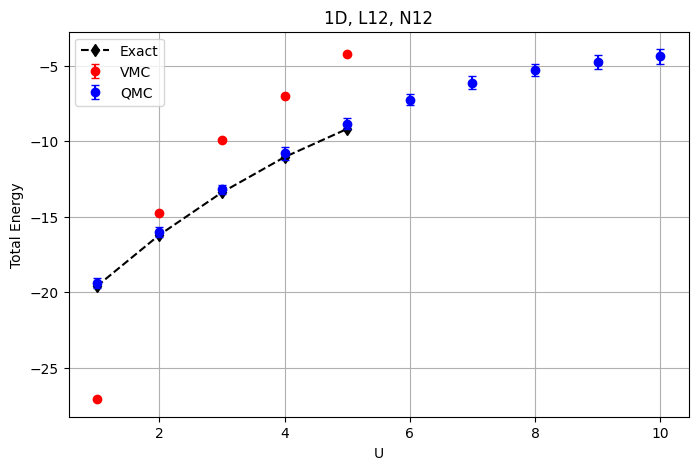

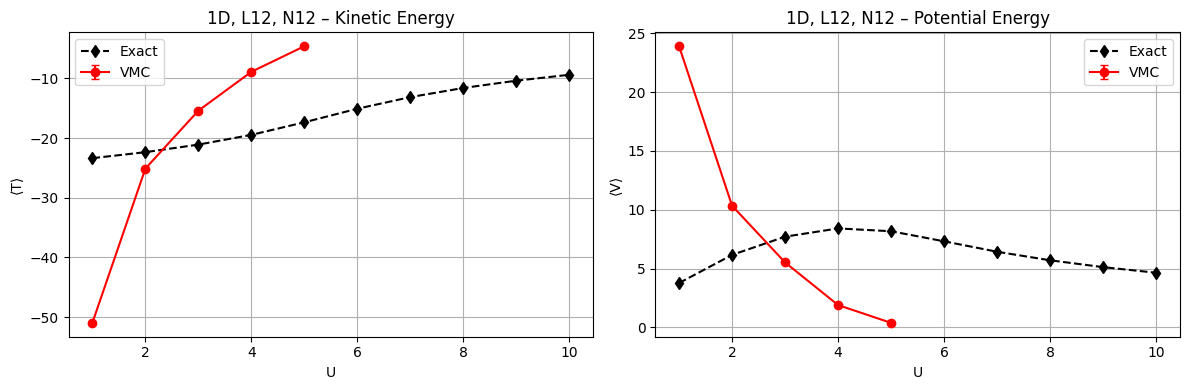

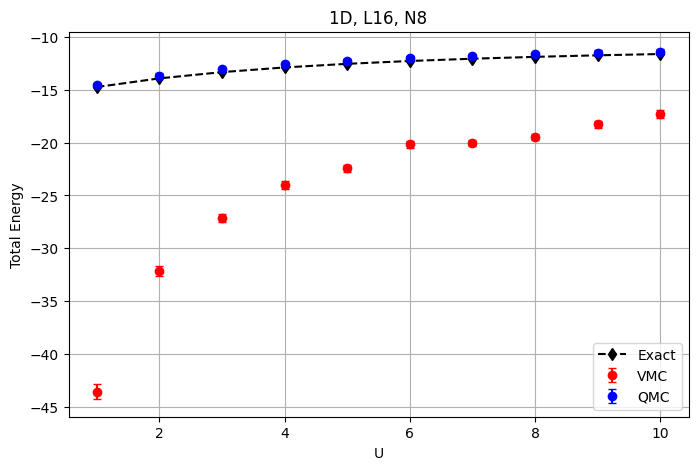

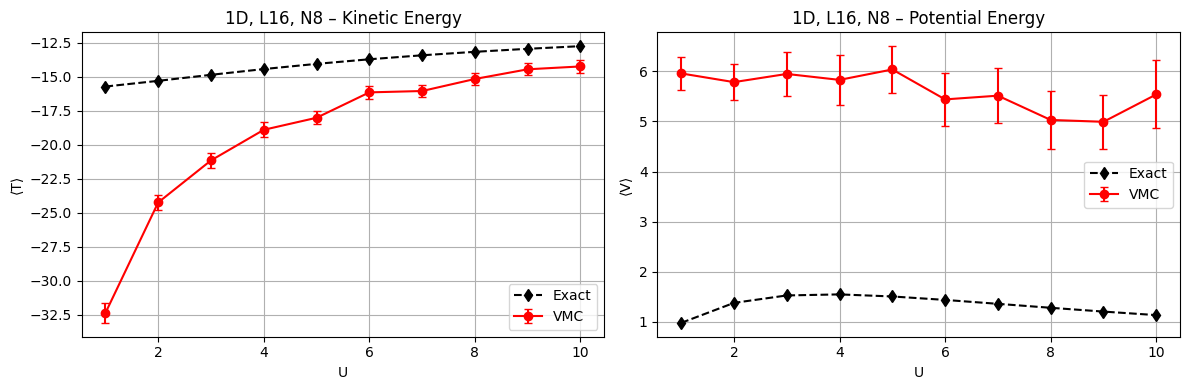

❌ Failed for 1D L8_N16: [Errno 2] No such file or directory: '../data/GC/1D/L8_N16/VMC_results.dat'


In [12]:
# Define list of (L, N) pairs
benchmark_pairs = [(12, 12), (16, 8), (8, 16)]

# Run processing for all pairs
process_benchmark_setups(benchmark_pairs, base_dir="../data", type="GC", save_dir="./figures/", plot=True)

# 1D Benchmarking for 12 particles and 12 sites
Ran PIMC with the following:

julia pigsfli.jl -D 1 -L 12 -N 12 -l 2 -U [1.0-10.0] --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

# 1D Benchmarking for 16 sites and 8 particles
Ran PIMC with the following:

julia pigsfli.jl -D 1 -L 8 -N 16 -l 2 -U [1.0-10.0] --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

# 1D Benchmarking for 8 sites and 16 particles
Ran PIMC with the following:

julia pigsfli.jl -D 1 -L 16 -N 8 -l 2 -U [1.0-10.0] --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

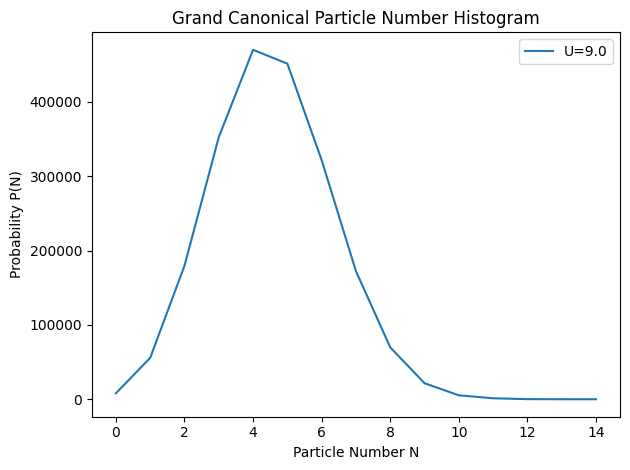

In [29]:
import glob

files = sorted(glob.glob("../data/GC/1D/L12_N12/PN_hist_U*.dat"))

for file in files:
    data = np.loadtxt(file, comments="#")
    if data.ndim == 1:
        data = data[None, :]  # handle single-line case

    N_vals = data[:, 0]
    counts = data[:, 1]
    # counts /= counts.sum()  # Normalize

    U = file.split("U")[-1].split(".dat")[0]
    plt.plot(N_vals, counts, label=f"U={U}")

plt.xlabel("Particle Number N")
plt.ylabel("Probability P(N)")
plt.title("Grand Canonical Particle Number Histogram")
plt.legend()
plt.tight_layout()
plt.show()

# QMC Beta Zero (1e-5) Testing for Canonical Simulation

In [14]:
# File paths (adjust if needed)
k_file = "../data/QMC/1D_L12_N12_beta0.00001/K_1D_L12_N12_M12_l2_U1.0000_t1.0000_beta0.0000_binsize10000_seed2001_square_trialstate_constant.dat"
v_file = "../data/QMC/1D_L12_N12_beta0.00001/V_1D_L12_N12_M12_l2_U1.0000_t1.0000_beta0.0000_binsize10000_seed2001_square_trialstate_constant.dat"

# Load data
df_k = pd.read_csv(k_file, delim_whitespace=True, header=None)
df_v = pd.read_csv(v_file, delim_whitespace=True, header=None)

# Compute statistics
k_mean = df_k[0].mean()
k_std = df_k[0].std()

v_mean = df_v[0].mean()
v_std = df_v[0].std()

# Total energy and uncertainty
QMC_total_mean = k_mean + v_mean
total_std = np.sqrt(k_std**2 + v_std**2)

# Print results
print(f"Kinetic Energy: {k_mean:.6f} ± {k_std:.6f}")
print(f"Potential Energy: {v_mean:.6f} ± {v_std:.6f}")
print(f"Total Energy: {QMC_total_mean:.6f} ± {total_std:.6f}")

Kinetic Energy: -23.500000 ± 46.305420
Potential Energy: 10.155380 ± 0.104717
Total Energy: -13.344620 ± 46.305538


In [15]:
# Load file, skipping comments
file_path = "../data/exact/1D_L12_N12.dat"
df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)

# Assign column names
df.columns = [
    "U", "Total_E", "Kinetic_E", "Potential_E", "col4", "col5", "col6",
    "col7", "col8", "col9"
]

# Filter directly for U = 1.0
row = df[df["U"] == 1.0]

if not row.empty:
    exact_total = row.iloc[0]["Total_E"]
    kinetic = row.iloc[0]["Kinetic_E"]
    potential = row.iloc[0]["Potential_E"]
    print(f"U = 1.0")
    print(f"Total Energy     = {exact_total}")
    print(f"Kinetic Energy   = {kinetic}")
    print(f"Potential Energy = {potential}")
else:
    print("U = 1.0 not found.")

U = 1.0
Total Energy     = -19.6072204913
Kinetic Energy   = -23.37460653662
Potential Energy = 3.767386045315


In [16]:
# Path to the file
file_path = "../data/C/1D/L12_N12/VMC_results.dat"

# Read data, skipping comments
df = pd.read_csv(file_path, delim_whitespace=True, comment="#", header=None)

# Assign column names
df.columns = ["U", "Kappa", "Energy", "SEM"]

# Filter directly for U = 1.0
row = df[df["U"] == 1.0]

# Extract and display
if not row.empty:
    vmc_energy = row.iloc[0]["Energy"]
    sem = row.iloc[0]["SEM"]
    print(f"U = 1.0")
    print(f"Energy = {vmc_energy}")
    print(f"SEM = {sem}")
else:
    print("U = 1.0 not found in the file.")

U = 1.0
Energy = -19.31658042215663
SEM = 0.0003036208153681


In [18]:
print(f"QMC at beta=0.00001: E = {abs(QMC_total_mean - exact_total)}\n")
print(f"VMC: E = {abs(vmc_energy - exact_total)}")

QMC at beta=0.00001: E = 6.262600491300006

VMC: E = 0.2906400691433717


# 2D Benchmarking for 4 particles on a 2x2 lattice 
Ran PIMC with the following:

julia pigsfli.jl -D 2 -L 16 -N 16 -l 2 -U [1.0-10.0] --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

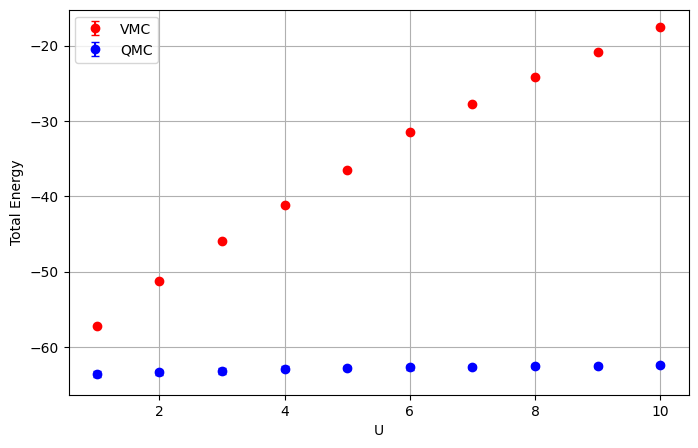

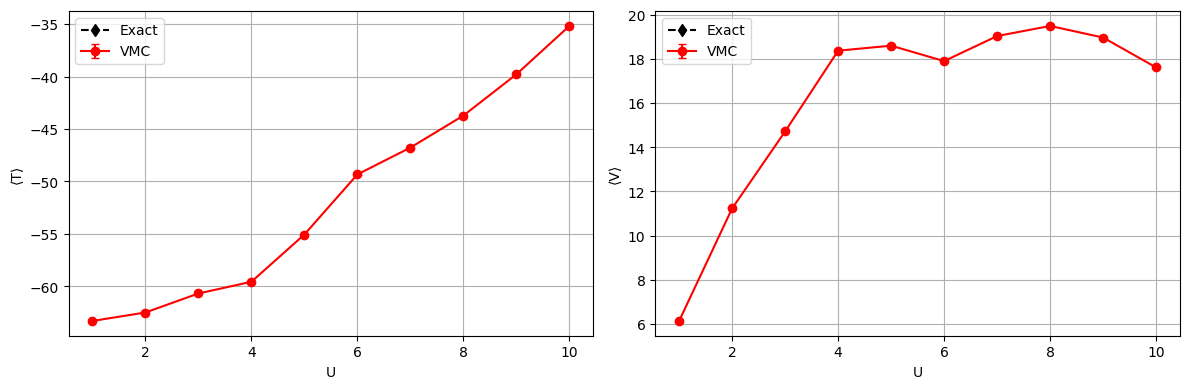

In [109]:
# Define list of (L, N) pairs
benchmark_pairs = [(16, 16)]

# Run processing for all pairs
process_benchmark_setups(benchmark_pairs, dim="2D", M_override=256, save_dir="./figures/", plot=True)